# SAX

Download the dataset penguin.csv from OpenOlat. First, calcuate the Eucledian distance of both time series. Afterwards, follow th esteps of the SAX algorithm and compare the distance of both strings. What do you observe?

---

In [1]:
import pandas as pd
import numpy as np
import math
from sklearn import preprocessing
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import string

## Implementation of the SAX (Symbolic Aggregate Approximation) Algorithm

In [18]:
class SAX(object):
    """
    This class is for computing common things with the Symbolic
    Aggregate approXimation method.  In short, this translates
    a series of data to a string, which can then be compared with other
    such strings using a lookup table.
    """

    def __init__(self, wordSize = 9, alphabetSize = 10, epsilon = 1e-6):

        if alphabetSize < 3 or alphabetSize > 20:
            raise DictionarySizeIsNotSupported()
        self.aOffset = ord('a')
        self.wordSize = wordSize
        self.alphabetSize = alphabetSize
        self.eps = epsilon
        self.breakpoints = {'3' : [-0.43, 0.43],
                            '4' : [-0.67, 0, 0.67],
                            '5' : [-0.84, -0.25, 0.25, 0.84],
                            '6' : [-0.97, -0.43, 0, 0.43, 0.97],
                            '7' : [-1.07, -0.57, -0.18, 0.18, 0.57, 1.07],
                            '8' : [-1.15, -0.67, -0.32, 0, 0.32, 0.67, 1.15],
                            '9' : [-1.22, -0.76, -0.43, -0.14, 0.14, 0.43, 0.76, 1.22],
                            '10': [-1.28, -0.84, -0.52, -0.25, 0, 0.25, 0.52, 0.84, 1.28],
                            '11': [-1.34, -0.91, -0.6, -0.35, -0.11, 0.11, 0.35, 0.6, 0.91, 1.34],
                            '12': [-1.38, -0.97, -0.67, -0.43, -0.21, 0, 0.21, 0.43, 0.67, 0.97, 1.38],
                            '13': [-1.43, -1.02, -0.74, -0.5, -0.29, -0.1, 0.1, 0.29, 0.5, 0.74, 1.02, 1.43],
                            '14': [-1.47, -1.07, -0.79, -0.57, -0.37, -0.18, 0, 0.18, 0.37, 0.57, 0.79, 1.07, 1.47],
                            '15': [-1.5, -1.11, -0.84, -0.62, -0.43, -0.25, -0.08, 0.08, 0.25, 0.43, 0.62, 0.84, 1.11, 1.5],
                            '16': [-1.53, -1.15, -0.89, -0.67, -0.49, -0.32, -0.16, 0, 0.16, 0.32, 0.49, 0.67, 0.89, 1.15, 1.53],
                            '17': [-1.56, -1.19, -0.93, -0.72, -0.54, -0.38, -0.22, -0.07, 0.07, 0.22, 0.38, 0.54, 0.72, 0.93, 1.19, 1.56],
                            '18': [-1.59, -1.22, -0.97, -0.76, -0.59, -0.43, -0.28, -0.14, 0, 0.14, 0.28, 0.43, 0.59, 0.76, 0.97, 1.22, 1.59],
                            '19': [-1.62, -1.25, -1, -0.8, -0.63, -0.48, -0.34, -0.2, -0.07, 0.07, 0.2, 0.34, 0.48, 0.63, 0.8, 1, 1.25, 1.62],
                            '20': [-1.64, -1.28, -1.04, -0.84, -0.67, -0.52, -0.39, -0.25, -0.13, 0, 0.13, 0.25, 0.39, 0.52, 0.67, 0.84, 1.04, 1.28, 1.64]
                            }
        self.beta = self.breakpoints[str(self.alphabetSize)]
        self.build_letter_compare_dict()
        self.scalingFactor = 1


    def to_letter_rep(self, x):
        """
        Function takes a series of data, x, and transforms it to a string representation
        """
        (paaX, indices) = self.to_PAA(self.normalize(x))
        self.scalingFactor = np.sqrt(len(x) / self.wordSize)
        return (self.alphabetize(paaX), indices)

    def normalize(self, x):
        """
        Function will normalize an array (give it a mean of 0, and a
        standard deviation of 1) unless it's standard deviation is below
        epsilon, in which case it returns an array of zeros the length
        of the original array.
        """
        X = np.asanyarray(x)
        if X.std() < self.eps:
            return [0 for entry in X]
        return (X-X.mean())/X.std()

    def to_PAA(self, x):
        """
        Funciton performs Piecewise Aggregate Approximation on data set, reducing
        the dimension of the dataset x to w discrete levels. returns the reduced
        dimension data set, as well as the indicies corresponding to the original
        data for each reduced dimension
        """
        n = len(x)
        stepFloat = n/float(self.wordSize)
        step = int(math.ceil(stepFloat))
        frameStart = 0
        approximation = []
        indices = []
        i = 0
        while frameStart <= n-step:
            thisFrame = np.array(x[frameStart:int(frameStart + step)])
            approximation.append(np.mean(thisFrame))
            indices.append((frameStart, int(frameStart + step)))
            i += 1
            frameStart = int(i*stepFloat)
        return (np.array(approximation), indices)

    def alphabetize(self,paaX):
        """
        Converts the Piecewise Aggregate Approximation of x to a series of letters.
        """
        alphabetizedX = ''
        for i in range(0, len(paaX)):
            letterFound = False
            for j in range(0, len(self.beta)):
                if paaX[i] < self.beta[j]:
                    alphabetizedX += chr(self.aOffset + j)
                    letterFound = True
                    break
            if not letterFound:
                alphabetizedX += chr(self.aOffset + len(self.beta))
        return alphabetizedX

    def compare_strings(self, sA, sB, x=None):
        """
        Compares two strings based on individual letter distance
        Requires that both strings are the same length
        """
        
        if x != None:
            self.scalingFactor = np.sqrt(x / self.wordSize)
        
        if len(sA) != len(sB):
            raise StringsAreDifferentLength()
        list_letters_a = [x for x in sA]
        list_letters_b = [x for x in sB]
        mindist = 0.0
        for i in range(0, len(list_letters_a)):
            mindist += self.compare_letters(list_letters_a[i], list_letters_b[i])**2
        mindist = self.scalingFactor* np.sqrt(mindist)
        return mindist

    def compare_letters(self, la, lb):
        """
        Compare two letters based on letter distance return distance between
        """
        return self.compareDict[la+lb]

    def build_letter_compare_dict(self):
        """
        Builds up the lookup table to determine numeric distance between two letters
        given an alphabet size.  Entries for both 'ab' and 'ba' will be created
        and will have identical values.
        """

        number_rep = range(0,self.alphabetSize)
        letters = [chr(x + self.aOffset) for x in number_rep]
        self.compareDict = {}
        for i in range(0, len(letters)):
            for j in range(0, len(letters)):
                if np.abs(number_rep[i]-number_rep[j]) <=1:
                    self.compareDict[letters[i]+letters[j]] = 0
                else:
                    high_num = np.max([number_rep[i], number_rep[j]])-1
                    low_num = np.min([number_rep[i], number_rep[j]])
                    self.compareDict[letters[i]+letters[j]] = self.beta[high_num] - self.beta[low_num]

    def sliding_window(self, x, numSubsequences = None, overlappingFraction = None):
        if not numSubsequences:
            numSubsequences = 20
        self.windowSize = int(len(x)/numSubsequences)
        if not overlappingFraction:
            overlappingFraction = 0.9
        overlap = self.windowSize*overlappingFraction
        moveSize = int(self.windowSize - overlap)
        if moveSize < 1:
            raise OverlapSpecifiedIsNotSmallerThanWindowSize()
        ptr = 0
        n = len(x)
        windowIndices = []
        stringRep = []
        while ptr < n-self.windowSize+1:
            thisSubRange = x[ptr:ptr+self.windowSize]
            (thisStringRep,indices) = self.to_letter_rep(thisSubRange)
            stringRep.append(thisStringRep)
            windowIndices.append((ptr, ptr+self.windowSize))
            ptr += moveSize
        return (stringRep,windowIndices)

    def batch_compare(self, xStrings, refString):
        return [self.compare_strings(x, refString) for x in xStrings]

    def set_scaling_factor(self, scalingFactor):
        self.scalingFactor = scalingFactor

    def set_window_size(self, windowSize):
        self.windowSize = windowSize


### Helper Method for plotting

In [19]:
# Nothing to do here

def plot_SAX(timeSeries, sax):
    
    """Helper Method to plot final result, 
    requires a dataFrame with columns paa1 and paa2 and a SAX object."""

    timeSeries.plot(y=["paa1", "paa2"], use_index=True)
    alphabet = list(string.ascii_lowercase)
    segments = sax.breakpoints[str(sax.alphabetSize)]

    for i in range(len(segments)):
        plt.axhline(segments[i], color='r', linestyle='--', label=alphabet[i])

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

---

### Load dataset into pandas DataFrame

### Plot Data

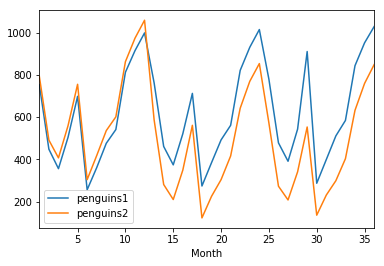

### Create SAX object

## Step 1: Standardize the data

### Compute euclidean distance

2.93400325909


## Step 2: Use PAA to approximate your data

### Plot PAA transformed data

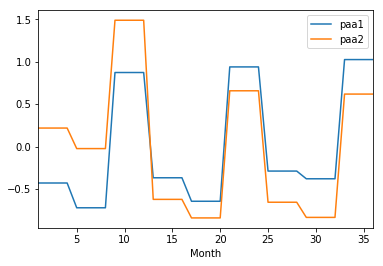

2.80919882525


## Step 3: Replace your data distribution with symbolic representation

### Calculate distance between the resulting strings

1.47186955944


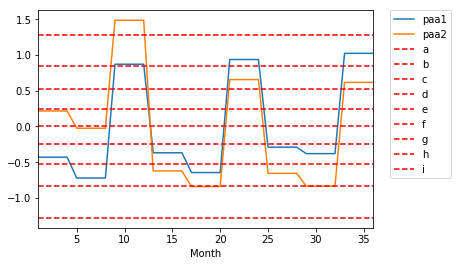

---

### Which parameters can you adjust to improve the SAX algorithm?